In [1]:
import utils
import plotting
import numpy as np
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning

# ignore these because they don't seem to apply
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from PyPDF2 import PdfFileMerger

from copy import deepcopy

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plot_dir = "../../../plots/ttsfs/23Jan11"

import os

_ = os.system(f"mkdir -p {plot_dir}")

In [4]:
samples = {
    "QCD": "QCD",
    "Single Top": "ST",
    "TTSL": "TTToSemiLeptonic",
    "TTbar": ["TTTo2L2Nu", "TTToHadronic"],
    "W+Jets": "WJets",
    "Diboson": ["WW", "WZ", "ZZ"],
    "Data": "SingleMuon",
}

top_matched_key = "TT Top Matched"

data_dir = "../../../../data/ttsfs/Dec22/"
year = "2018"

# filters = [("('ak8FatJetPt', '0')", ">=", 500)]
filters = None

events_dict = utils.load_samples(data_dir, samples, year, filters=filters)

Finding QCD samples
Loading QCD_HT300to500
Loaded 0 entries
Loading QCD_HT200to300
Loaded 0 entries
Loading QCD_HT700to1000
Loaded 473 entries
Loading QCD_HT1000to1500
Loaded 210 entries
Loading QCD_HT100to200
Loaded 0 entries
Loading QCD_HT2000toInf
Loaded 83 entries
Loading QCD_HT1500to2000
Loaded 227 entries
Loading QCD_HT50to100
Loaded 0 entries
Loading QCD_HT500to700
Loaded 191 entries
Finding Single Top samples
Loading ST_tW_antitop_5f_NoFullyHadronicDecays
Loaded 34510 entries
Loading ST_tW_top_5f_NoFullyHadronicDecays
Loaded 34435 entries
Loading ST_t-channel_top_4f_InclusiveDecays
Loaded 24918 entries
Loading ST_tW_top_5f_inclusiveDecays
Loaded 13306 entries
Loading ST_tW_antitop_5f_inclusiveDecays
Loaded 12637 entries
Loading ST_s-channel_4f_leptonDecays
Loaded 10706 entries
Loading ST_t-channel_top_5f_InclusiveDecays
Loaded 22282 entries
Loading ST_t-channel_antitop_4f_InclusiveDecays
Loaded 12606 entries
Loading ST_t-channel_antitop_5f_InclusiveDecays
Loaded 9276 entries
Fi

In [5]:
utils.get_cutflow(f"{data_dir}/{year}/TTToSemiLeptonic/pickles", year, "TTToSemiLeptonic")

OrderedDict([('met', 1141398.0),
             ('ak8_jet', 1537404.0),
             ('lepW', 1079665.0),
             ('ak4_jet', 666328.0),
             ('top_has_bs', 665774.0),
             ('muon', 11072011.0),
             ('all', 124529836),
             ('npvsGood', 124529850.0)])

In [6]:
events_dict[top_matched_key] = events_dict["TTSL"].loc[events_dict["TTSL"]["top_matched"][0] == 1]
events_dict["TT W Matched"] = events_dict["TTSL"].loc[events_dict["TTSL"]["w_matched"][0] == 1]
events_dict["TT Unmatched"] = pd.concat(
    [events_dict["TTbar"], events_dict["TTSL"].loc[events_dict["TTSL"]["unmatched"][0] == 1]]
)
# del events_dict["TTSL"]
# del events_dict["TTbar"]

In [11]:
# normalize scale factors to average to 1
for key in ["lp_sf", "lp_sf_lnN"]:
    # cut off at 10
    events_dict[top_matched_key].loc[:, key] = np.minimum(
        events_dict[top_matched_key].loc[:, key].values, 10
    )
    mean_lp_sfs = np.mean(events_dict[top_matched_key][key], axis=0)
    events_dict[top_matched_key].loc[:, key] = (
        events_dict[top_matched_key].loc[:, key] / mean_lp_sfs
    ).values


In [9]:
events_dict[top_matched_key]["lp_sf"]

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
13,0.269824,0.207545,0.197171,0.219372,0.354263,0.214593,0.265296,0.375458,0.470224,0.271851,...,0.192086,0.216789,0.245024,0.308117,0.235695,0.478114,0.111967,0.286354,0.296120,0.263749
16,1.283855,1.214948,1.664319,0.177340,0.713796,0.704038,1.409735,0.598115,0.720771,0.206755,...,0.746492,0.000000,0.818211,0.683528,0.930770,0.201069,1.311403,1.543557,0.990351,1.131609
20,1.321673,3.174354,1.511851,1.640584,2.910360,0.838533,1.271311,0.989437,1.277771,2.368112,...,1.059376,1.365176,1.104815,2.166728,1.529013,3.872882,1.471551,1.215822,0.950540,1.984872
43,0.340238,0.781123,0.226841,0.207031,0.210696,0.210335,0.309599,0.151946,0.548658,0.373638,...,0.337832,0.161649,0.400830,0.380674,0.354690,0.385519,0.288818,0.597934,0.060188,0.073764
49,1.286634,3.713242,0.619204,2.644705,0.932575,0.343020,2.122082,0.446062,0.213771,0.817111,...,1.396118,0.778059,0.219782,0.048664,0.532710,0.760060,0.172083,0.859687,0.093099,5.279100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681770,2.776407,2.614633,1.621112,0.145503,0.187100,2.121373,1.642240,0.640977,0.032831,1.388617,...,1.213565,1.306781,2.127837,1.982255,0.409787,2.334621,0.975212,10.000000,5.537026,1.443862
681786,1.392630,0.551113,0.657049,0.934031,0.499972,1.718376,1.210629,0.590594,0.618158,2.091829,...,3.415292,0.917882,0.594379,5.773801,2.481809,1.236134,0.417754,0.000000,0.101106,0.755467
681794,0.131110,0.016566,0.000000,0.297506,0.180751,0.051193,0.000000,0.000000,0.226313,0.209720,...,0.150371,0.102695,0.431774,0.000000,0.000000,0.071959,0.272112,0.423620,0.000000,0.000000
681806,6.651182,0.806961,0.133254,10.000000,0.328653,10.000000,10.000000,10.000000,6.739978,1.498739,...,0.000000,2.400704,10.000000,7.403480,1.438529,0.492689,10.000000,0.000000,0.401758,0.596462


Text(0.5, 1.0, 'Scale factor distribution')

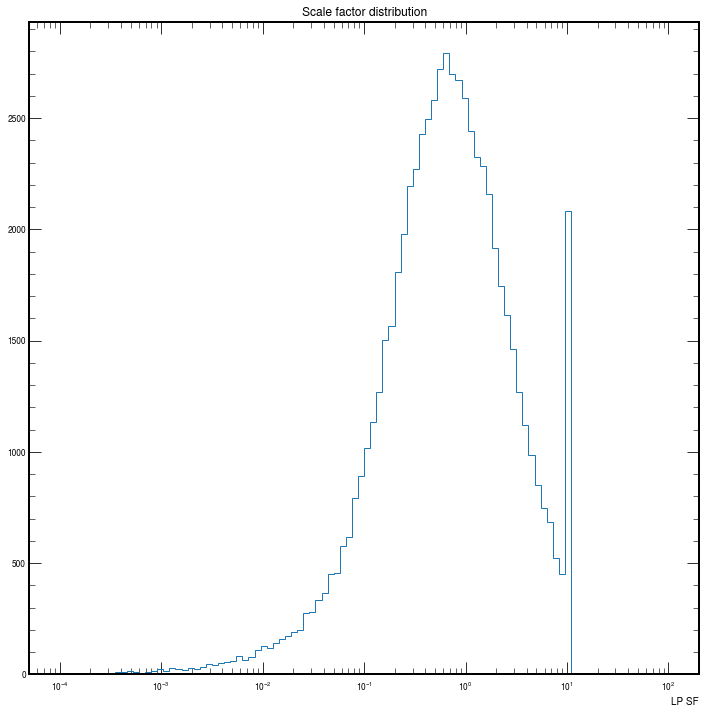

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
_ = plt.hist(events_dict[top_matched_key]["lp_sf"][0].values, np.logspace(-4, 2, 101, base=10), histtype='step')
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("LP SF")
plt.title("Scale factor distribution")

In [8]:
# for key in events_dict:
#     if key == top_matched_key:
#         events_dict[key]["total_weight"] = events_dict[key]["weight"].values * events_dict[key]["lp_sf"]
#         events_dict[key]["total_weight_err"] = (
#             events_dict[key]["weight"] * events_dict[key]["lp_sf_err"]
#         )
#     else:
#         events_dict[key]["total_weight"] = events_dict[key]["weight"]
#         events_dict[key]["total_weight_err"] = events_dict[key]["weight"] * 0

In [12]:
for key in events_dict:
    # events_dict[key] = events_dict[key][events_dict[key]["ak8FatJetPt"][0] >= 500]
    events_dict[key] = events_dict[key][events_dict[key]["ak8FatJetMsd"][0] >= 50]

In [13]:
plot_samples = [
    "QCD",
    "Diboson",
    "Single Top",
    "W+Jets",
    "TT Unmatched",
    "TT W Matched",
    top_matched_key,
]

### Pre plots

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


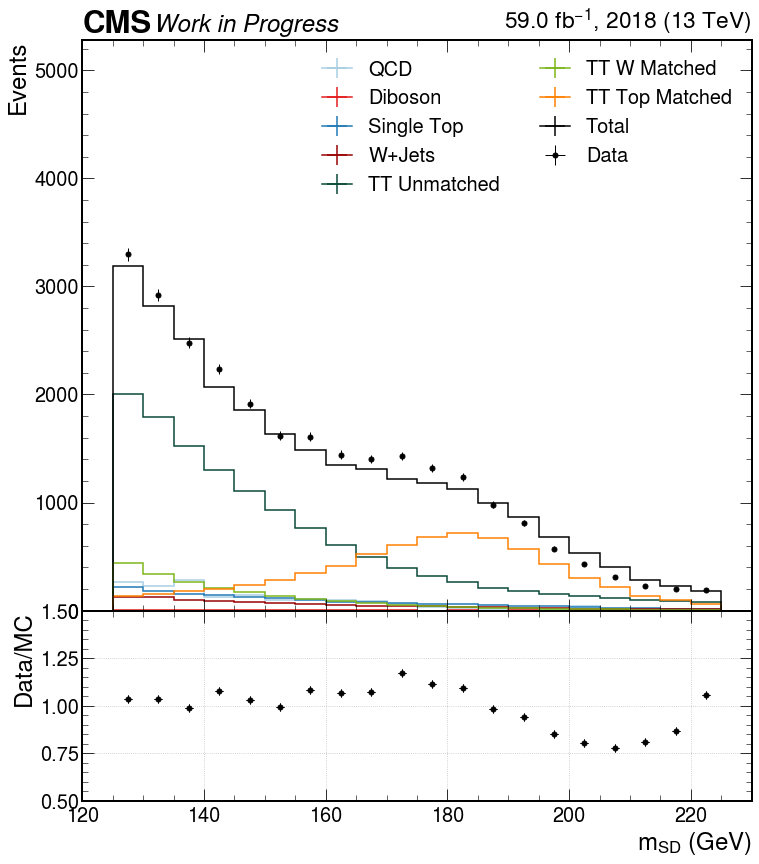

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


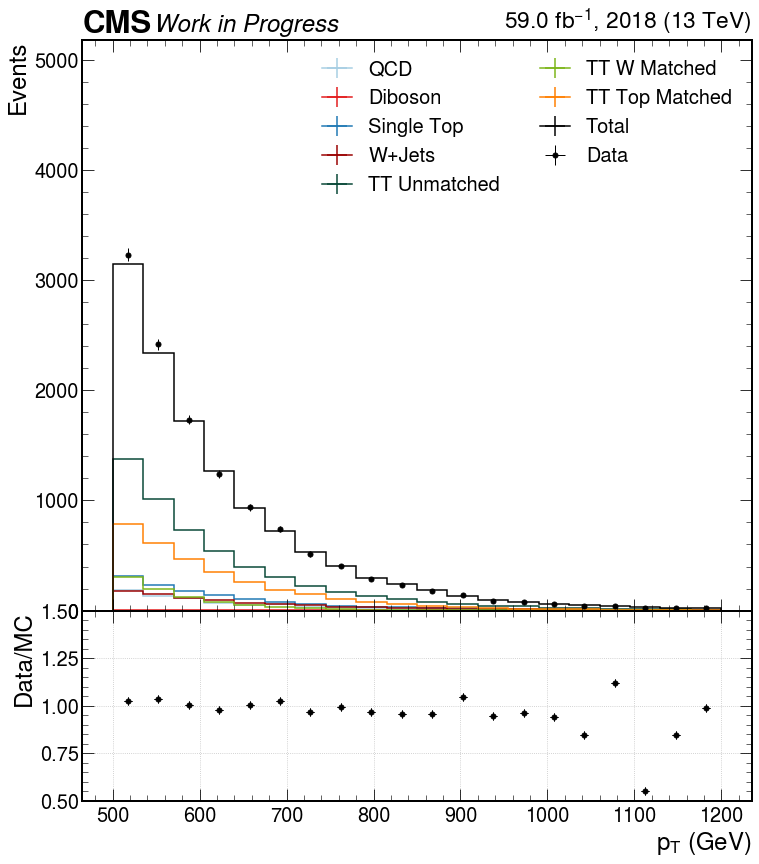

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


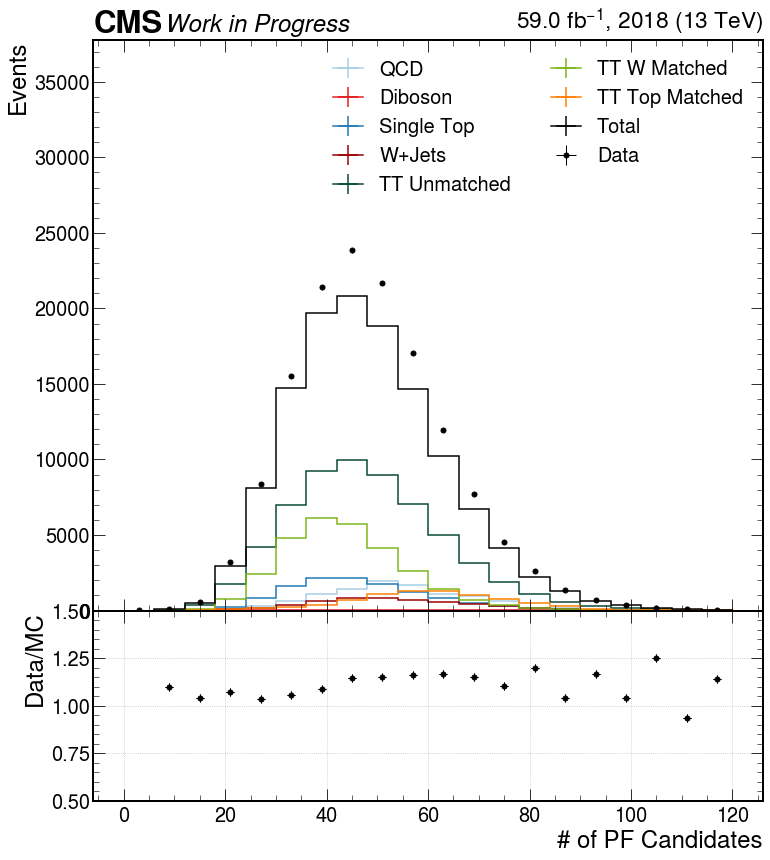

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


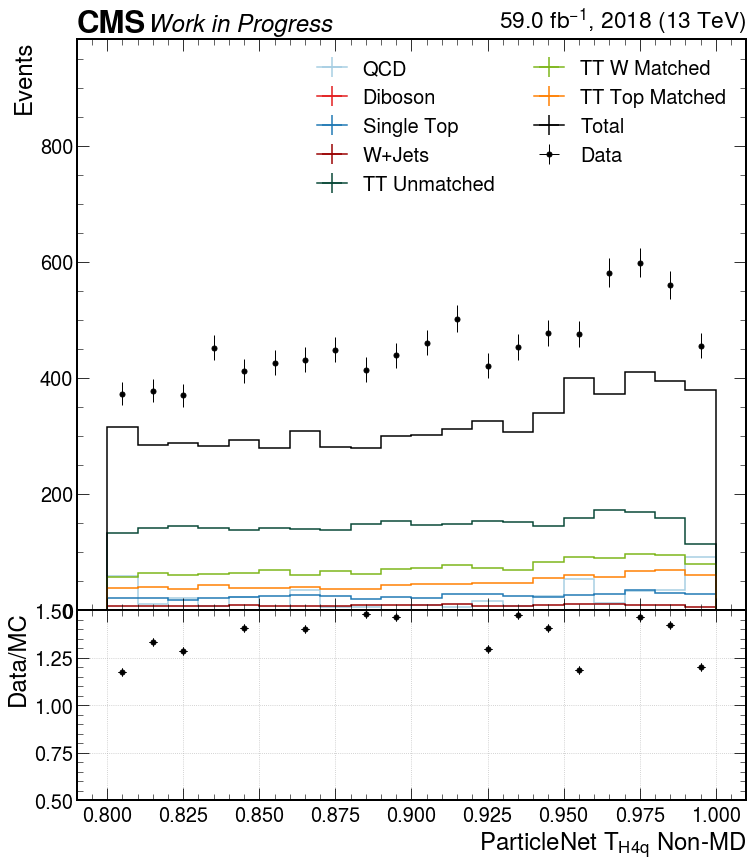

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


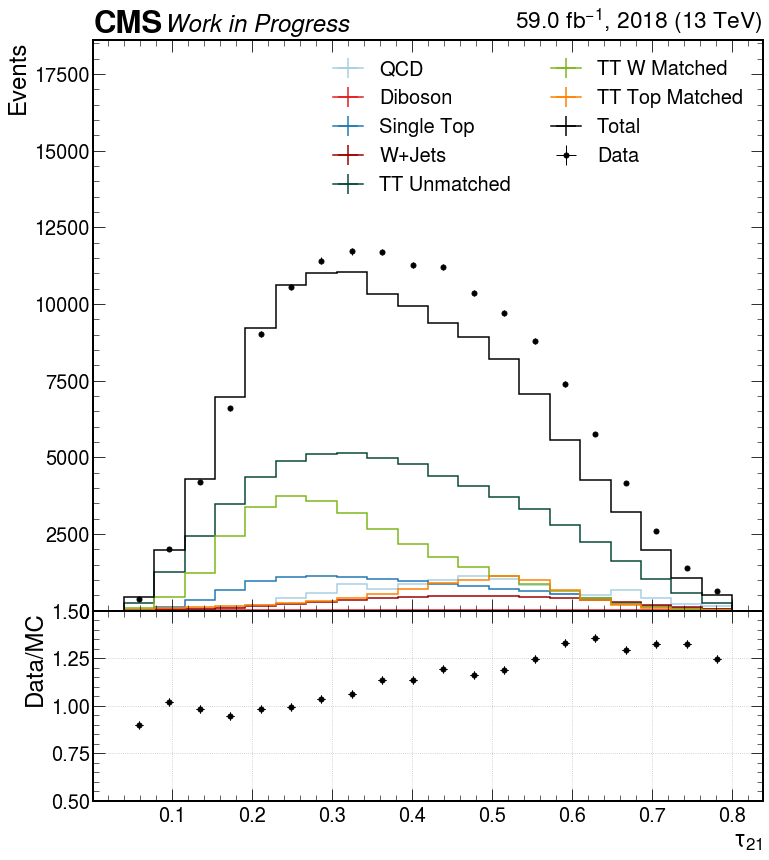

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


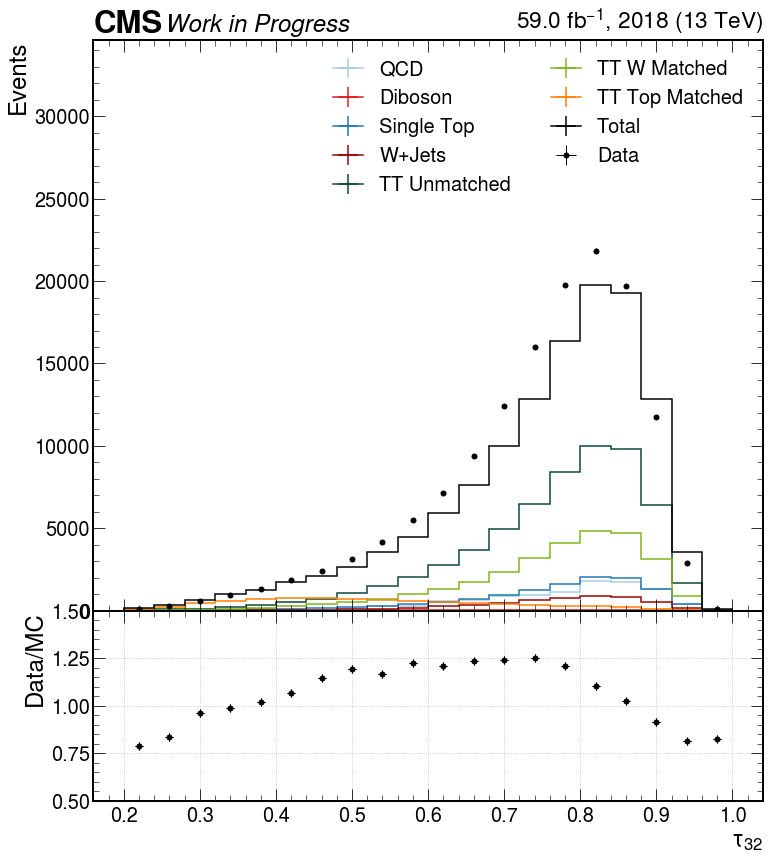

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


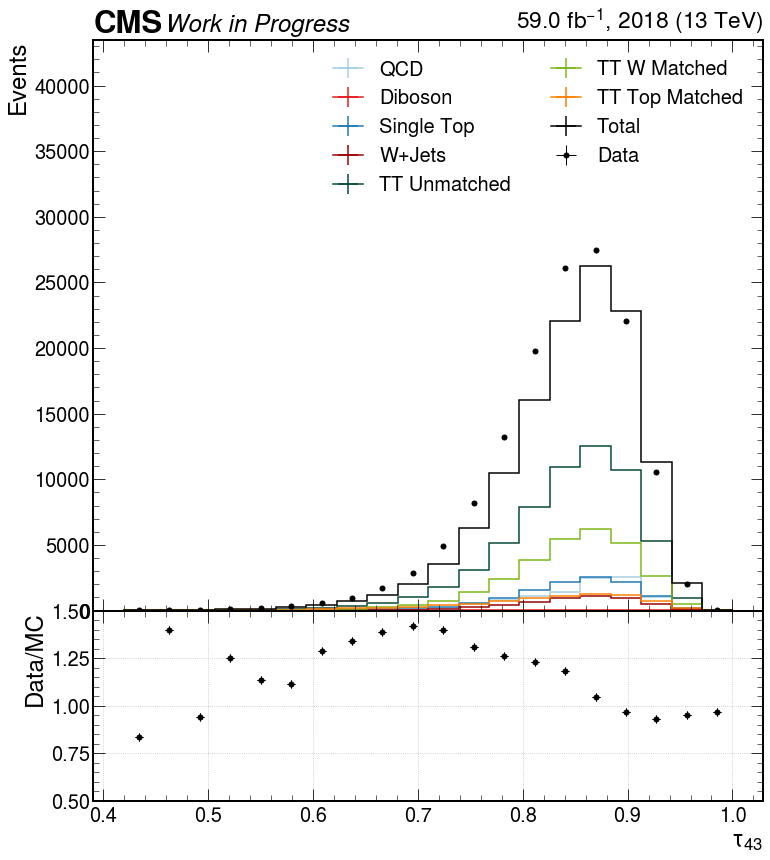

In [14]:
# {var: (bins, label)}
plot_vars = {
    "ak8FatJetMass": ([20, 125, 225], r"$m_{SD}$ (GeV)"),
    "ak8FatJetPt": ([20, 500, 1200], r"$p_T$ (GeV)"),
    "ak8FatJetnPFCands": ([20, 0, 120], r"# of PF Candidates"),
    "ak8FatJetParticleNet_Th4q": ([20, 0.8, 1], r"ParticleNet $T_{H4q}$ Non-MD"),
    "tau21": ([20, 0.04, 0.8], r"$\tau_{21}$"),
    "tau32": ([20, 0.2, 1], r"$\tau_{32}$"),
    "tau43": ([20, 0.42, 1], r"$\tau_{43}$"),
}

pre_hists = {}

for var, (bins, label) in plot_vars.items():
    if var not in pre_hists:
        pre_hists[var] = utils.singleVarHistNoMask(
            events_dict, var, bins, label, weight_key="weight"
        )

merger_pre_plots = PdfFileMerger()

for var, var_hist in pre_hists.items():
    name = f"{plot_dir}/pre_{var}.pdf"
    plotting.ratioLinePlot(
        var_hist,
        plot_samples,
        year,
        bg_err=None,
        name=name,
    )
    merger_pre_plots.append(name)

# merger_pre_plots.write(f"{plot_dir}/PrePlots.pdf")
# merger_pre_plots.close()

### Post plots

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(
/Users/raghav/Documents/CERN/hhbbww/HHbbVV/src/HHbbVV/scale_factors/plotting.py:212: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bg_err == "ratio":


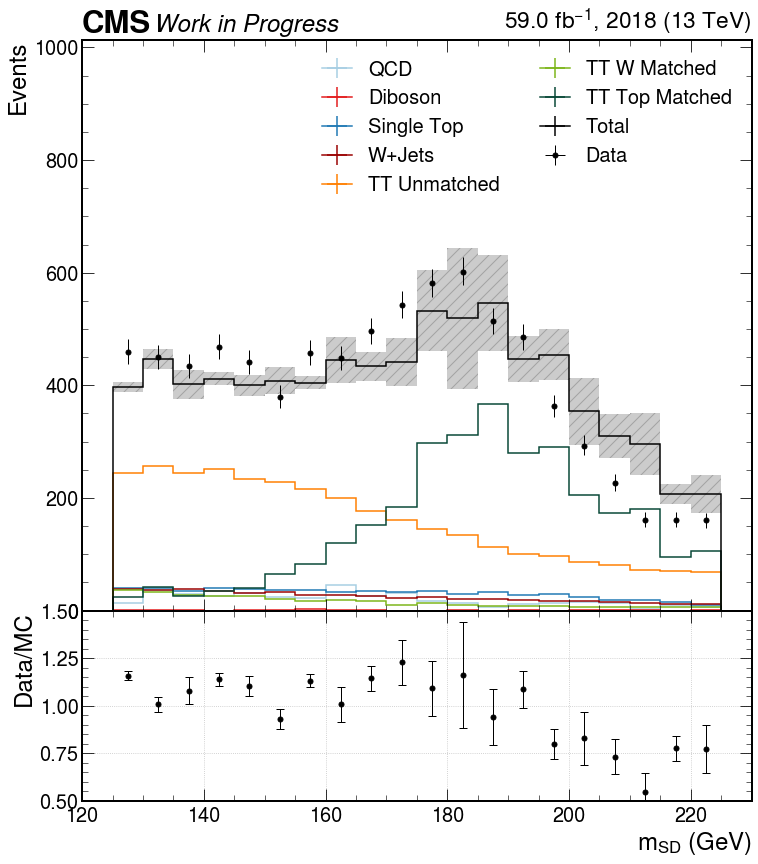

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(
/Users/raghav/Documents/CERN/hhbbww/HHbbVV/src/HHbbVV/scale_factors/plotting.py:212: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bg_err == "ratio":


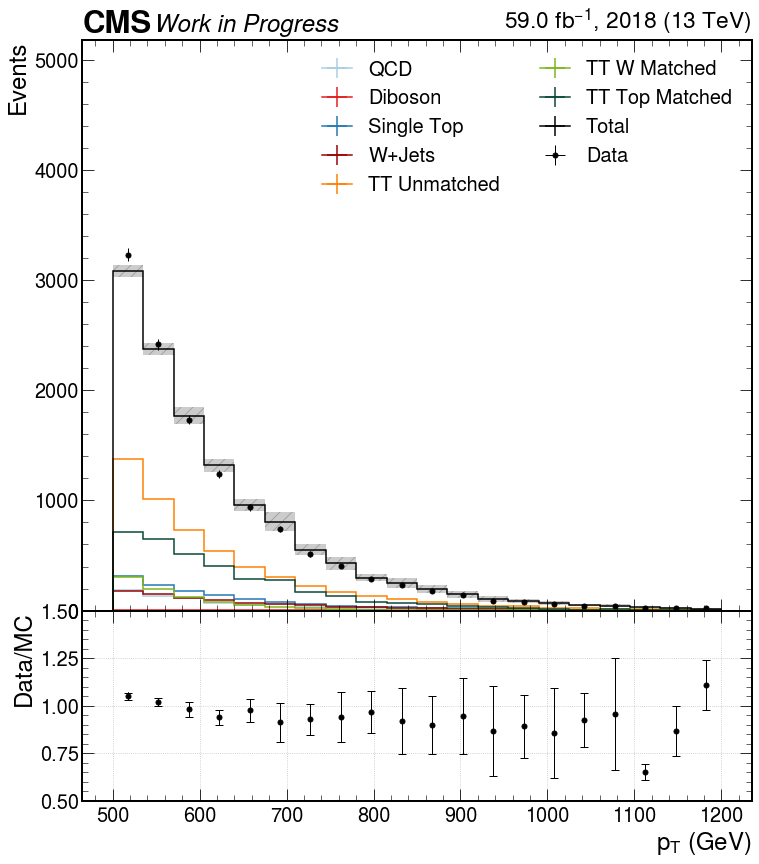

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(
/Users/raghav/Documents/CERN/hhbbww/HHbbVV/src/HHbbVV/scale_factors/plotting.py:212: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bg_err == "ratio":


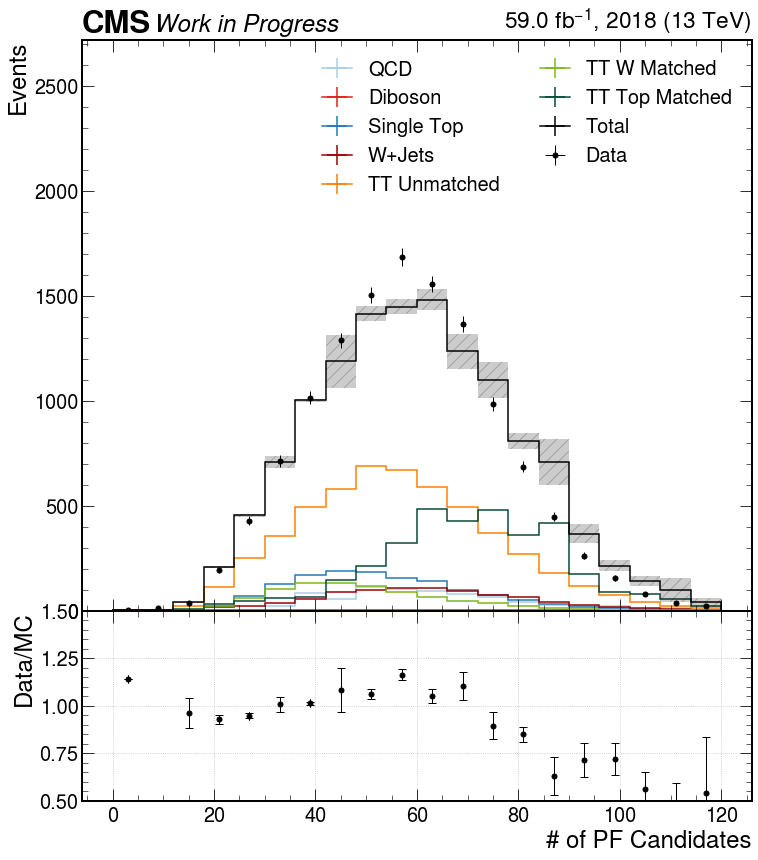

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(
/Users/raghav/Documents/CERN/hhbbww/HHbbVV/src/HHbbVV/scale_factors/plotting.py:212: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bg_err == "ratio":


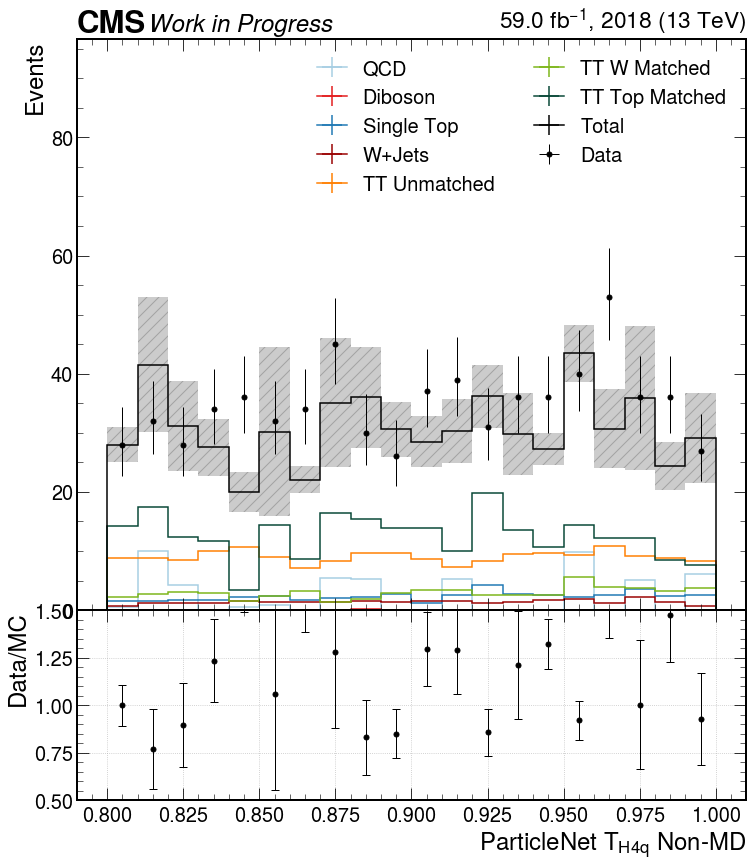

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(
/Users/raghav/Documents/CERN/hhbbww/HHbbVV/src/HHbbVV/scale_factors/plotting.py:212: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bg_err == "ratio":


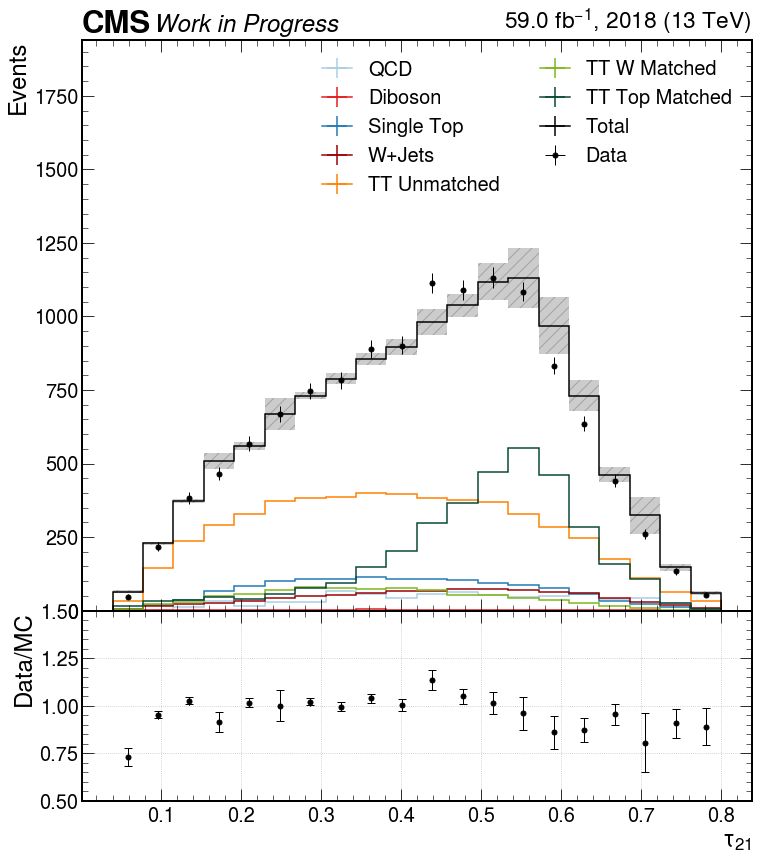

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(
/Users/raghav/Documents/CERN/hhbbww/HHbbVV/src/HHbbVV/scale_factors/plotting.py:212: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bg_err == "ratio":


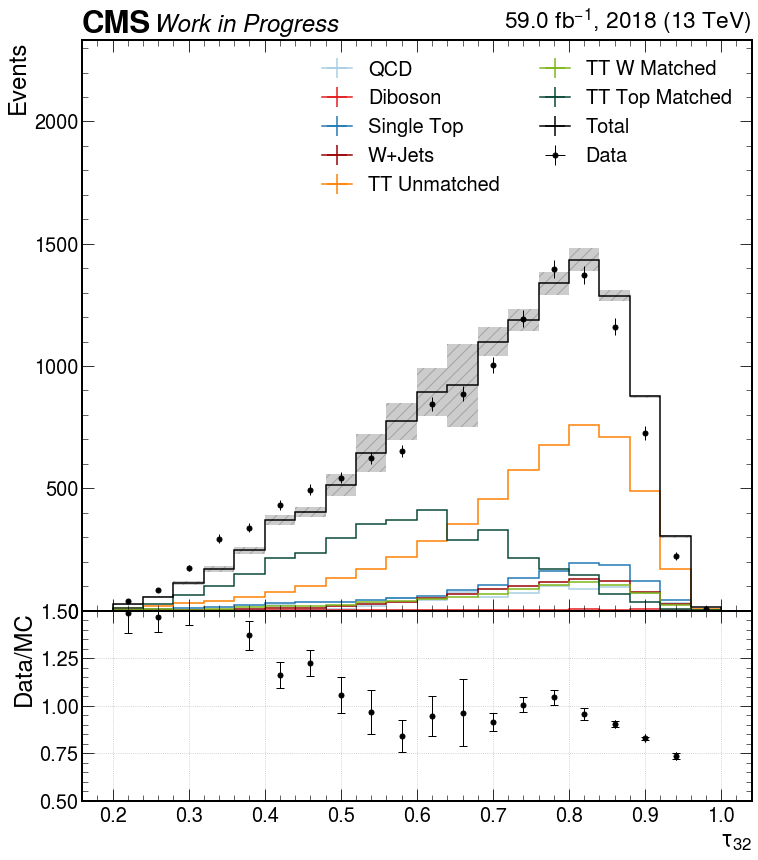

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(
/Users/raghav/Documents/CERN/hhbbww/HHbbVV/src/HHbbVV/scale_factors/plotting.py:212: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bg_err == "ratio":


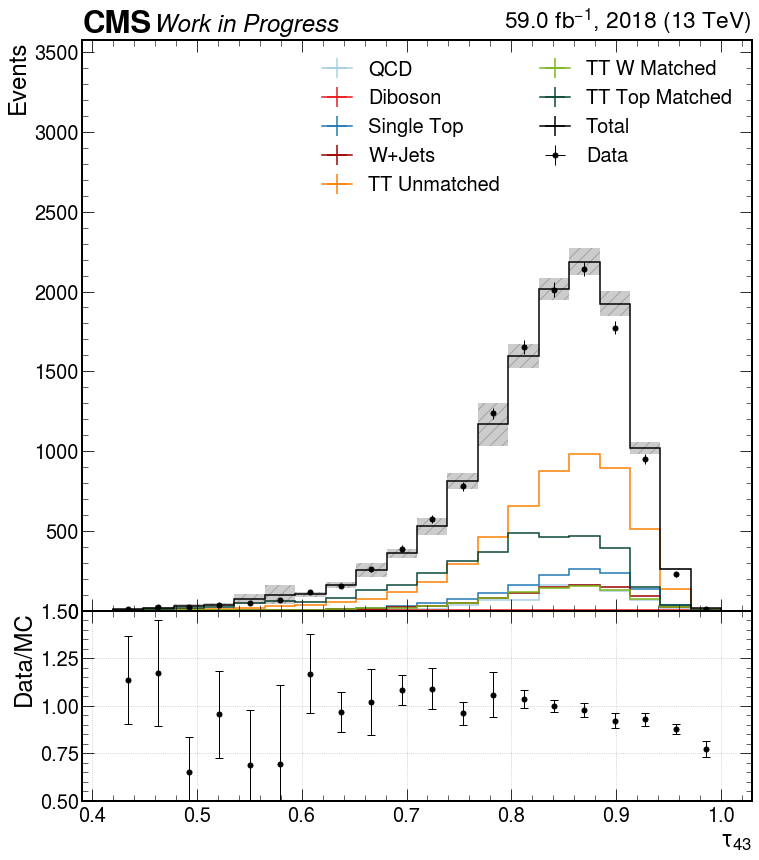

In [18]:
post_hists = {}
post_hists_err = {}

events = events_dict[top_matched_key]

for var, (bins, label) in plot_vars.items():
    if var not in post_hists:
        toy_hists = []
        for i in range(events["lp_sf"].shape[1]):
            toy_hists.append(
                np.histogram(
                    events[var][0].values.squeeze(),
                    np.linspace(*bins[1:], bins[0] + 1),
                    weights=events["weight"][0].values * events["lp_sf"][i].values,
                )[0]
            )

        nom_vals = toy_hists[0]  # first column are nominal values
        unc = np.minimum(nom_vals, np.std(toy_hists[1:], axis=0))  # cap at 100% unc

        thist = deepcopy(pre_hists[var])
        top_matched_key_index = np.where(np.array(list(thist.axes[0])) == top_matched_key)[0][0]
        thist.view(flow=False)[top_matched_key_index, :].value = nom_vals
        post_hists[var] = thist
        post_hists_err[var] = unc


merger_post_plots = PdfFileMerger()

for var, var_hist in post_hists.items():
    name = f"{plot_dir}/post_{var}.pdf"
    plotting.ratioLinePlot(
        var_hist,
        plot_samples,
        year,
        bg_err=post_hists_err[var],
        name=name,
    )
    merger_post_plots.append(name)

# merger_post_plots.write(f"{plot_dir}/PostPlots.pdf")
# merger_post_plots.close()

### Post LnN Plots

In [ ]:
post_hists = {}
post_hists_err = {}

events = events_dict[top_matched_key]

for var, (bins, label) in plot_vars.items():
    if var not in post_hists:
        toy_hists = []
        for i in range(events["lp_sf_lnN"].shape[1]):
            toy_hists.append(
                np.histogram(
                    events[var][0].values.squeeze(),
                    np.linspace(*bins[1:], bins[0] + 1),
                    weights=events["weight"][0].values * events["lp_sf_lnN"][i].values,
                )[0]
            )

        nom_vals = toy_hists[0]  # first column are nominal values
        unc = np.minimum(nom_vals, np.std(toy_hists, axis=0))  # cap at 100% unc

        thist = deepcopy(pre_hists[var])
        top_matched_key_index = np.where(np.array(list(thist.axes[0])) == top_matched_key)[0][0]
        thist.view(flow=False)[top_matched_key_index, :].value = nom_vals
        post_hists[var] = thist

        post_hists_err[var] = unc


merger_post_plots = PdfFileMerger()

for var, var_hist in post_hists.items():
    name = f"{plot_dir}/postlnN_{var}.pdf"
    plotting.ratioLinePlot(
        var_hist,
        plot_samples,
        year,
        bg_err=post_hists_err[var],
        name=name,
    )
    merger_post_plots.append(name)

# merger_post_plots.write(f"{plot_dir}/PostLnNPlots.pdf")
# merger_post_plots.close()

In [22]:
mass_hist = utils.singleVarHistNoMask(
    events_dict, "ak8FatJetMass", [20, 125, 225], r"$m_{SD}$", weight_key="weight"
)

In [ ]:
plotting.ratioHistPlot(
    mass_hist,
    ["QCD", "Diboson", "Single Top", "W+Jets", "TT Unmatched", "TT W Matched", top_matched_key],
    f"{plot_dir}/",
)